# Create Scatter Plots Showing Diversity in Heat Wave and Cold Snap Parameters


In [2]:
# Start by importing the packages we need:
import os
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import timedelta


## Suppress Future Warnings


In [4]:
# Suppress future warnings:
warnings.simplefilter(action='ignore', category=FutureWarning)


## Set the Directory Structure

In [5]:
# Identify the top-level directory and the subdirectory where the data will be stored:
hw_cs_data_dir =  '/Users/burl878/Documents/Code/code_repos/gdo_climate_toolsuite_visualizations/data/'
image_output_dir =  '/Users/burl878/Documents/Code/code_repos/gdo_climate_toolsuite_visualizations/plots/'


## Choose the Time Window for Identifying Coincident Events


In [6]:
# Set the time (in +/- days) over which to identify coincident events across NERC regions:
time_window = 3


## Process the Heat Wave and Cold Snap Library


In [21]:
# Define a function to extract the heat wave or cold snap data for a given NERC region and definition:
def process_hw_cs_data(hw_cs_data_dir: str, hw_cs: str, region: int, definition: int):
    
    if hw_cs == 'HW':
       # Read in the raw data from the heat wave library:
       df = pd.read_csv((hw_cs_data_dir + 'hw_library_expanded.csv'))
    elif hw_cs == 'CS':
       # Read in the raw data from the cold snap library:
       df = pd.read_csv((hw_cs_data_dir + 'cs_library_expanded.csv'))

    # Subset to just the data for definition you want to use:
    subset_df = df[(df['Def'] == definition)].copy()

    # Reset the index:
    subset_df.reset_index(inplace=True, drop=True)
    
    # Loop over the rows of the dataframe and find number of corresponding events within X days of the event in a given row:
    for row in range(len(subset_df)):
        # Subset the data to just events in the library within X days of the event in a given row:
        time_subset_df = subset_df[(pd.to_datetime(subset_df['Start']) > (pd.to_datetime(subset_df['Center'].iloc[row]) - pd.Timedelta(time_window, 'd'))) & 
                                   (pd.to_datetime(subset_df['End']) < (pd.to_datetime(subset_df['Center'].iloc[row]) + pd.Timedelta(time_window, 'd')))].copy()

        # Store the size of that subset:
        if time_subset_df.empty == False:
           subset_df.at[row, 'Regions_Impacted'] = time_subset_df.shape[0]
        else:
           subset_df.at[row, 'Regions_Impacted'] = 1

    # Subset to just the data for region you want to use:
    subset_df = subset_df[(subset_df['NERC'] == region)].copy()
    
    # Bin the spatial coverage values and scale them for the scatter plot:
    subset_df['Coverage_Normalized'] = ((subset_df['Coverage'] - subset_df['Coverage'].min()) / (subset_df['Coverage'].max() - subset_df['Coverage'].min())).round(2)

    # Bin the regions impacted values and scale them for the scatter plot:
    subset_df['Regions_Impacted_Normalized'] = ((subset_df['Regions_Impacted'] - 1) / (subset_df['Regions_Impacted'].max() - 1)).round(2)
    
    # Reset the index:
    subset_df.reset_index(inplace=True, drop=True)
    
    return subset_df


In [22]:
# Test the function:
output_df = process_hw_cs_data(hw_cs_data_dir = hw_cs_data_dir, 
                               hw_cs = 'HW',
                               region = 6,
                               definition = 5)

output_df


,UID,NERC,Region,Def,Start,End,Center,Center_DOY,T_Max_Min,Duration,Coverage,Regions_Impacted,Coverage_Normalized,Regions_Impacted_Normalized
0,NERC6_Def5_Event1,6,WECC: NWPP,5,2021-06-26,2021-06-30,2021-06-28,179,97.2,5,84.4,4.0,0.84,0.50
1,NERC6_Def5_Event2,6,WECC: NWPP,5,2006-07-20,2006-07-28,2006-07-22,203,93.5,9,94.7,1.0,0.99,0.00
2,NERC6_Def5_Event3,6,WECC: NWPP,5,2021-08-10,2021-08-16,2021-08-12,224,93.1,7,91.6,4.0,0.95,0.50
3,NERC6_Def5_Event4,6,WECC: NWPP,5,2020-08-15,2020-08-20,2020-08-16,229,92.7,6,94.7,2.0,0.99,0.17
4,NERC6_Def5_Event5,6,WECC: NWPP,5,1992-08-10,1992-08-19,1992-08-12,225,92.5,10,90.2,1.0,0.92,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,NERC6_Def5_Event190,6,WECC: NWPP,5,1994-07-16,1994-07-17,1994-07-17,198,83.1,2,48.4,3.0,0.28,0.33
190,NERC6_Def5_Event191,6,WECC: NWPP,5,2014-07-07,2014-07-08,2014-07-08,189,83.0,2,51.6,1.0,0.33,0.00
191,NERC6_Def5_Event192,6,WECC: NWPP,5,1981-09-07,1981-09-08,1981-09-08,251,83.0,2,29.8,1.0,0.00,0.00
192,NERC6_Def5_Event193,6,WECC: NWPP,5,1994-08-11,1994-08-12,1994-08-11,223,82.9,2,59.1,3.0,0.45,0.33


## Make the Plot


In [23]:
def plot_hw_cs_data(hw_cs_data_dir: str, hw_cs: str, region: int, definition: int, image_output_dir: str, image_resolution: int, save_images=False):

    # Read in NERC region name file and extract the name:
    nerc = pd.read_csv((hw_cs_data_dir + 'nerc_region_names.csv'))
    nerc_name = nerc.loc[nerc['number'] == region, 'short_name'].item()
    
    # Process the data using the function defined above:
    output_df = process_hw_cs_data(hw_cs_data_dir = hw_cs_data_dir, 
                                   hw_cs = hw_cs,
                                   region = region,
                                   definition = definition)

    # For cold snaps, shift the centroid date to plot whole winter seasons together:
    if hw_cs == 'CS':
       output_df.loc[(output_df['Center_DOY'] > 182), 'Center_DOY'] = output_df['Center_DOY']-365

    # Set the plot parameters based on plotting heat waves or cold snaps:
    if hw_cs == 'HW':
       cmap = plt.get_cmap('Reds', 21)
       xticks = [121, 152, 182, 213, 244, 274]
       xticklabels = ['May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']
       xmin = 121
       xmax = 274 
       ylabel = 'Maximum Temperature [$^\circ$F]'
       title = ('Heat Wave Events in ' + nerc_name + '\n Definition ' + str(definition) + ', 1980-2024, N=' + str(len(output_df)))
    elif hw_cs == 'CS':
       cmap = plt.get_cmap('Blues', 21)
       xticks = [-61, -31, 1, 32, 60, 91]
       xticklabels = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr']
       xmin = -61
       xmax = 91   
       ylabel = 'Minimum Temperature [$^\circ$F]'
       title = ('Cold Snap Events in ' + nerc_name + '\n Definition ' + str(definition) + ', 1980-2024, N=' + str(len(output_df)))
        
    # Make the plot:
    plt.figure(figsize=(20, 10))
    plt.rcParams['font.size'] = 18
    plt.rcParams['axes.axisbelow'] = True
    sc = plt.scatter(output_df['Center_DOY'], output_df['T_Max_Min'], s=(((output_df['Regions_Impacted_Normalized']+0.1)*750)), c=output_df['Duration'], 
                     edgecolors='k', cmap=cmap, vmin=0, vmax=21, label='Size $\\propto$ # of NERC Regions Impacted')
    cbar = plt.colorbar(sc, ticks=[0, 7, 14, 21])
    cbar.ax.set_ylabel('Event Duration [Days]')
    plt.legend(loc='best', prop={'size': 18})
    plt.grid()
    plt.xticks(xticks, xticklabels)
    plt.xlim([xmin, xmax])
    plt.ylim([(output_df['T_Max_Min'].min()-1), (output_df['T_Max_Min'].max()+1)])
    plt.ylabel(ylabel)
    plt.title(title)

    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       plt.savefig(os.path.join(image_output_dir + 'NERC' + str(region) + '_Def' + str(definition) + '_' + hw_cs + '_1980_2024.png'), dpi=image_resolution, bbox_inches='tight')


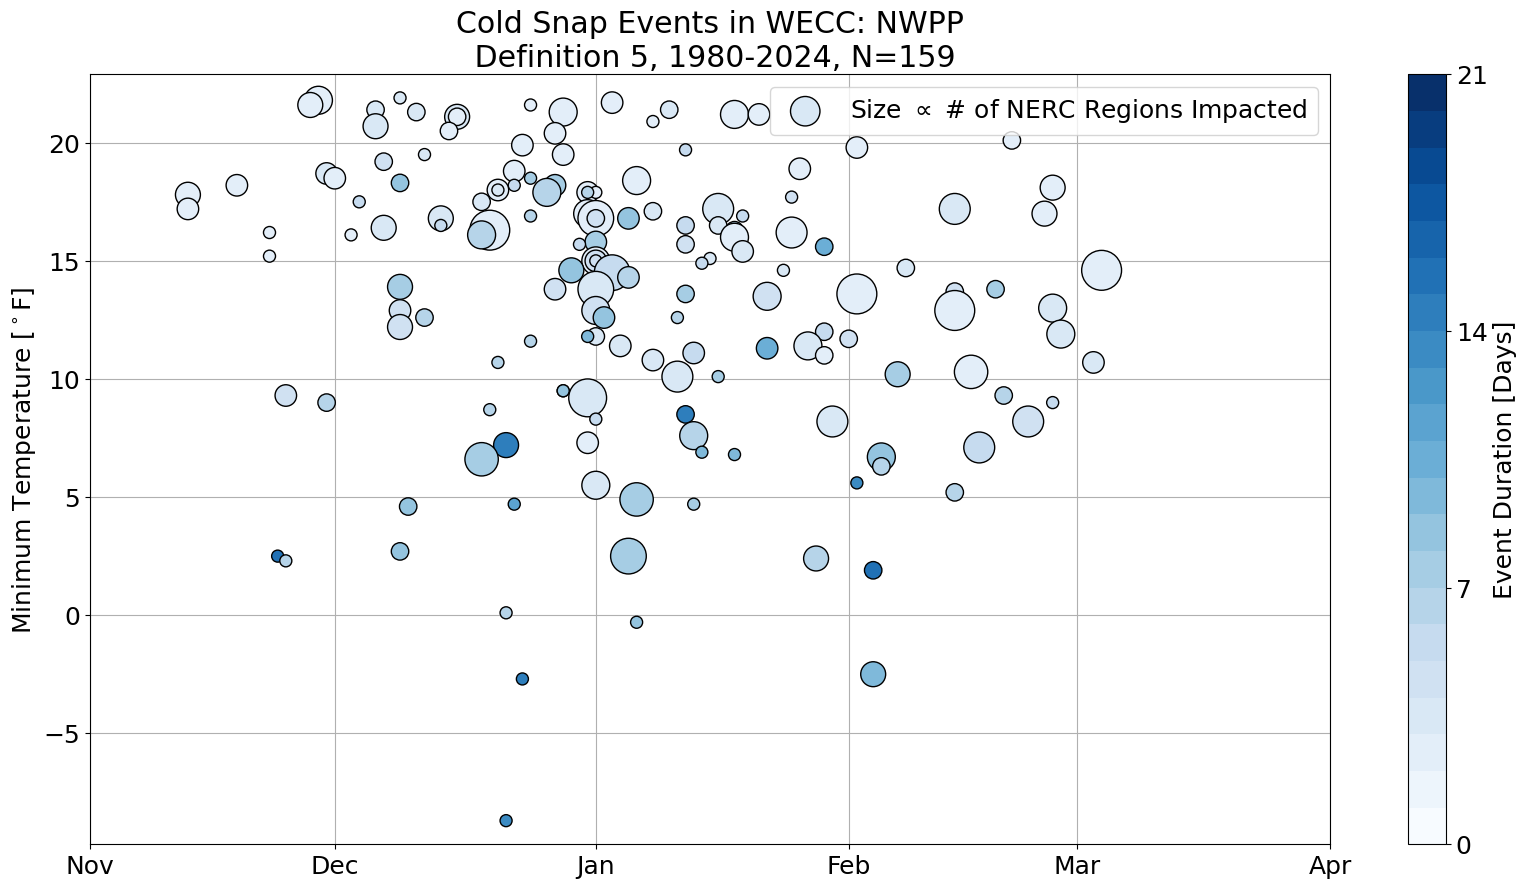

In [25]:
# Make the plot
plot_hw_cs_data(hw_cs_data_dir = hw_cs_data_dir, 
                hw_cs = 'CS',
                region = 6,
                definition = 5,
                image_output_dir = image_output_dir, 
                image_resolution = 150, 
                save_images = True)
